In [1]:
import os
import sys
import rootpath
sys.path.append(rootpath.detect())

import pickle
from testsuite.utilities import Pareto_split
import numpy as np
from testsuite.analysis import load_all, plot_all_pareto_2d, PLOT_STYLE, plot_measure
import matplotlib.pyplot as plt

In [2]:
pkl_dir = "./pkl_data/"
results_dir = "./log_data/"
result_dirs = sorted(os.listdir("./log_data/"))
filename = pkl_dir+'results.pkl'
if not os.path.isdir(pkl_dir):
    os.makedirs(pkl_dir)

In [3]:
try:
    pkl_loaded = True
#     raise FileNotFoundError
    infile = open(filename,'rb')
    results = pickle.load(infile)
    infile.close()
    print("results loaded from ", pkl_dir)
except FileNotFoundError:
    pkl_loaded = False 
    results = []
    for i, result_dir in enumerate(result_dirs):
        result = load_all(os.path.join(results_dir, result_dir))
        name = result_dir.split("_")[2]
        if "ei" in  result_dir:
            name+=" ei"
        elif "mean" in result_dir:
            name+=" $\mu$"
        else:
            pass
        result["name"] = name
        results.append(result)
    print("results loaded from ", results_dir)

for result in results:
    print(result["name"])

results loaded from  ./pkl_data/
Mpoi
ParEgo
Saf ei
Saf $\mu$
SmsEgo ei
SmsEgo $\mu$
lhs


In [4]:
from paralellizer import func, n_obj, test_function, x_limits, n_dim, n_obj

In [5]:
def scatter_nsphere(n_points, n_dims, weighting=None):
    """scatter n_points onto unit n-spere with n_dims dimensions"""
    if weighting is None:
        weighting = np.ones(n_dims)
    else:
        weighting = np.array(weighting)
    points = np.random.randn(n_points,n_dims)*weighting
    d = (points**2).sum(axis=1)**0.5
    norm_points = (points.T/d.T).T
    return np.abs(norm_points)

In [6]:
weighting = np.arange(1,n_obj+1)*2
y = scatter_nsphere(500, n_obj, weighting)

In [7]:
print("weighting:\t", weighting)
print("n_obj:\t\t", n_obj)
print("n_dim:\t\t", n_dim)

weighting:	 [2 4]
n_obj:		 2
n_dim:		 6


In [10]:
from pymoo.factory import get_performance_indicator
def extract_performance(z, indicator):
    ANS  = []
    for i in range(9, len(z)):
        p = Pareto_split(z[:i])[0]
        ans = indicator.calc(p)
        ANS.append(ans)

    return ANS

In [11]:
igdp = get_performance_indicator("igd+", y)
ref = np.ones(n_obj)*1.2
hv = get_performance_indicator("hv", ref_point=ref)

In [28]:
full_opt_line = (np.sum(ref)-(np.pi/4))
full_opt_line

1.6146018366025516

In [12]:
if not pkl_loaded:
    for result in results:
        ys_adjusted = [y/weighting for y in result["y"] if type(y) is np.ndarray]
        print(np.shape(ys_adjusted))
        result["igd"] = [extract_performance(y, igdp) for y in ys_adjusted]
        result["hpv"] = [extract_performance(y, hv) for y in ys_adjusted]
    
    lhs_ind = int(np.where([np.shape(result["hpv"]) == (0,) for result in results])[0])
    print("lhs index: \t", lhs_ind)

In [13]:
if not pkl_loaded:
    results[lhs_ind]["hpv"] = [[hv.calc(Pareto_split(y/weighting)[0]) for y in ys] for ys in results[lhs_ind]["y"]]
    results[lhs_ind]["igd"] = [[igdp.calc(Pareto_split(y/weighting)[0]) for y in ys] for ys in results[lhs_ind]["y"]]

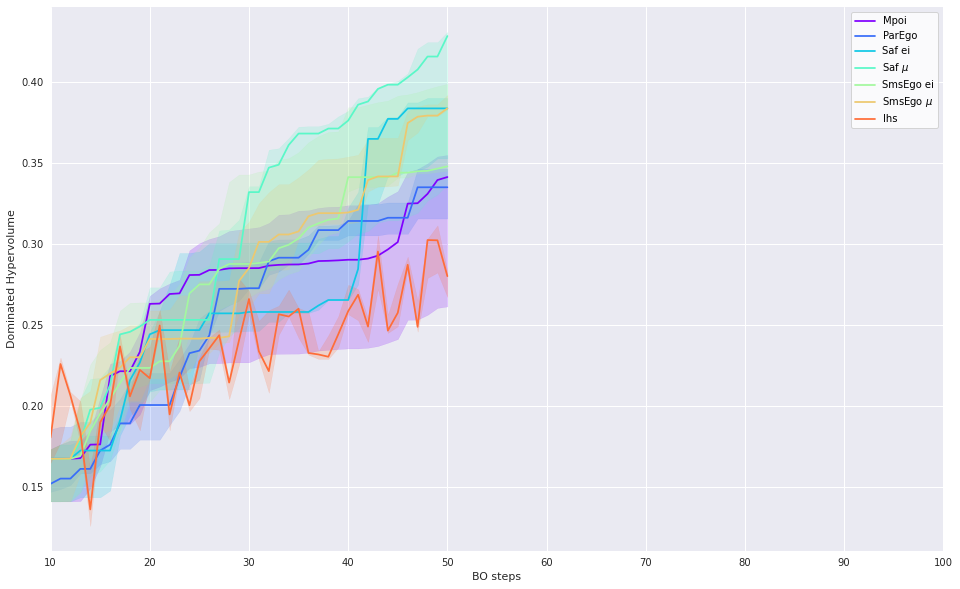

In [14]:
with plt.style.context(PLOT_STYLE["plot_style"]):
    fig_hv = plt.figure(figsize=[16, 10])
    ax_hv = fig_hv.gca()

cmap = PLOT_STYLE['plot_cmap']
colors = cmap(np.linspace(0, 1, len(result_dirs)+1))

for result, color in zip(results, colors):
    plot_measure(result, measure="hpv", axis=ax_hv, plot_individuals=False, label=result["name"], color=color)
ax_hv.set_xlim([10, 100])
ax_hv.set_xlabel("BO steps")
ax_hv.set_ylabel("Dominated Hypervolume")
ax_hv.legend()

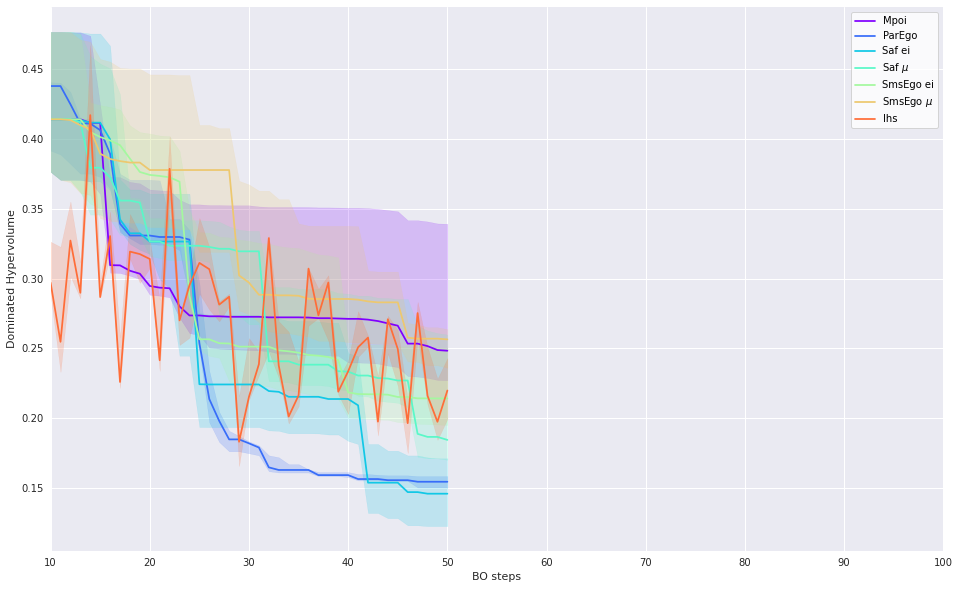

In [15]:
with plt.style.context(PLOT_STYLE["plot_style"]):
    fig_igd = plt.figure(figsize=[16, 10])
    ax_igd = fig_igd.gca()

cmap = PLOT_STYLE['plot_cmap']
colors = cmap(np.linspace(0, 1, len(result_dirs)+1))

for result, color in zip(results, colors):
    plot_measure(result, measure="igd", axis=ax_igd, plot_individuals=False, label=result["name"], color=color)
ax_igd.set_xlim([10, 100])
ax_igd.set_xlabel("BO steps")
ax_igd.set_ylabel("Dominated Hypervolume")
ax_igd.legend()

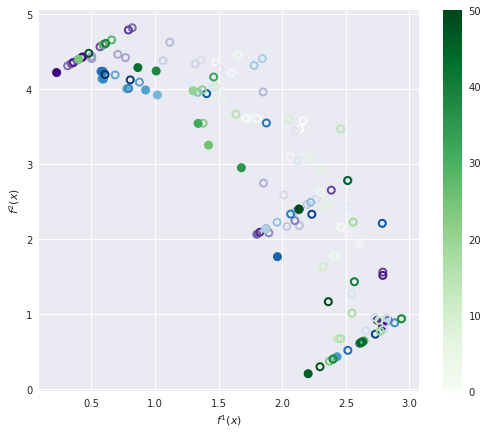

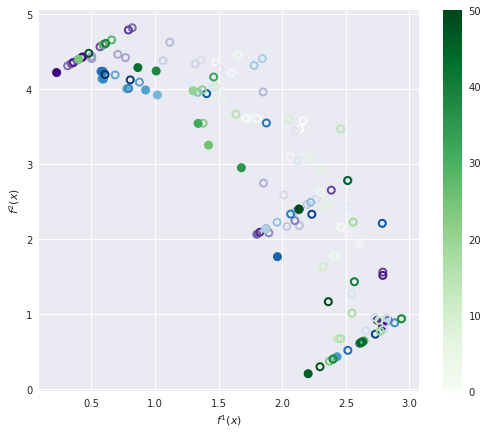

In [16]:
plot_all_pareto_2d(results[1])

In [17]:
if not pkl_loaded:
    outfile = open(filename,'wb')
    pickle.dump(results, outfile)
    outfile.close()